In [1]:
from subprocess import check_output
import os
import pandas as pd
import numpy as np
import scipy.stats as stats
import pybedtools
import logging
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, accuracy_score, recall_score
from sklearn.metrics import auc
from pybedtools.featurefuncs import midpoint
import pickle as pkl

logging.basicConfig(level='WARNING')

np.random.seed(1234)
window = 1e6


In [30]:
nearest = pd.read_csv('./data/closest_promoter.txt', sep='\t', index_col=0, header=None)
maxcor = pd.read_csv('./data/maxcor_promoter.txt', sep='\t', index_col=0, header=None)
rand = pd.read_csv('./data/random_promoter.txt', sep='\t', index_col=0, header=None)
tissue_map = pd.read_csv('./data/FANTOM_GTEx_tissue_match.csv', sep=',', index_col=None, header=0)
nearest.columns = ['promoter', 'score']
maxcor.columns = ['promoter', 'score']
rand.columns = ['promoter', 'score']



matched_tissue_auprs = dict()
related_tissue_auprs = dict()

for row in tissue_map.index:
    fantom_ids = [tissue_map.loc[row]['FANTOM_ID']]
    tissue = tissue_map.loc[row]['GTEx_name']
    ismatched = True if tissue_map.loc[row]['Match_type'] == 'Match' else False

    df = pd.DataFrame()
    for file in fantom_ids:
        df = df.append(
            pd.read_csv('./data/links.aggregated/%s.txt' % file, sep='\t', index_col=None, header=None))
#         df = df.append(
#             pd.read_csv('./data/link_total.aggregated/%s.txt' % file, sep='\t', index_col=None, header=None))
    df = df.reset_index(drop=True)
    df.columns = ['promoter', 'enhancer', 'score']

    df = df.sort_values(by=['enhancer', 'score'], ascending=[True, False], kind='mergesort')
    df = df.drop_duplicates(subset='enhancer', keep='first')
    df = df[df['score'] > 0]  # filtering
    df = df.set_index('enhancer')

    label = pd.read_csv('./data/eQTL_link/%s.eQTL_link.txt' % tissue, sep='\t', index_col=None, header=None)
    label.columns = ['promoter', 'enhancer']
    label = label.set_index('enhancer')

    act_en = pd.DataFrame()
    for file in fantom_ids:
        act_en = act_en.append(pd.read_csv('./data/enhancer_usage.aggregated/%s.txt' % file, sep='\t', index_col=None, header=None))
    act_en = act_en[act_en.iloc[:, 1]==1].iloc[:, 0].drop_duplicates().values
    # need to intersect all?: yep
    # only promoter exist in eQTL are consider for further calculation

    # intersection to label
    # our = df[[(i in label.index) and (i in act_en) for i in df.index]]
    # near = nearest[[(i in label.index) and (i in act_en) for i in nearest.index]]
    # mcor = maxcor[[(i in label.index) and (i in act_en) for i in maxcor.index]]
    # rd = rand[[(i in label.index) and (i in act_en) for i in rand.index]]

    our = df[[(i in label.index) for i in df.index]]
    near = nearest[[(i in label.index) for i in nearest.index]]
    mcor = maxcor[[(i in label.index) for i in maxcor.index]]
    rd = rand[[(i in label.index) for i in rand.index]]

    near['score'] = -near['score']

    pres = [our, near, mcor, rd]
    auprs = []
    for pre in pres:
        for i in range(pre.shape[0]):
            ind = pre.index[i]
            if pre.loc[ind]['promoter'] in label[label.index == ind]['promoter'].values:
                pre.loc[ind, 'confirm'] = True
            else:
                pre.loc[ind, 'confirm'] = False

        prec, rec, thr = precision_recall_curve(pre['confirm'].astype(np.bool).values, pre['score'].values)
        auprs.append(auc(rec, prec))
    if ismatched:
        matched_tissue_auprs[tissue + '-' + fantom_ids[0]] = auprs
    else:
        related_tissue_auprs[tissue + '-' + fantom_ids[0]] = auprs


/home1/alfred/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home1/alfred/anaconda3/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home1/alfred/anaconda3/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:964: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

In [7]:
# %matplotlib notebook
%matplotlib inline

In [41]:
# yerr = []
for name, auprs in zip(['Matched AUPR', 'Related AUPR'], [matched_tissue_auprs, related_tissue_auprs]):
    df = pd.DataFrame(auprs, index=['our', 'nearest', 'max_cor', 'random']).transpose()
    df.plot.bar(title=name, figsize=[12, 6])
    ax = df.plot.box(title=name)

plt.show()


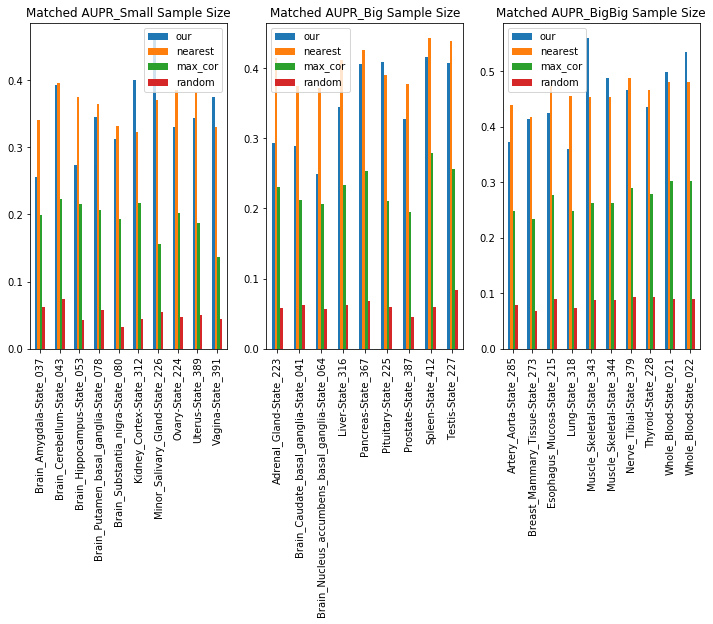

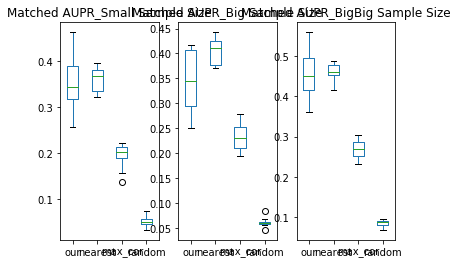

In [24]:
name, auprs = 'Matched AUPR', matched_tissue_auprs
df = pd.DataFrame(auprs, index=['our', 'nearest', 'max_cor', 'random']).transpose()

a = tissue_map['Sample_size'].quantile(0.33)
b = tissue_map['Sample_size'].quantile(0.66)

inx_s = tissue_map[tissue_map['Sample_size'] < a]['FANTOM_ID'].to_list()
inx_b = tissue_map[(tissue_map['Sample_size'] > a) & (tissue_map['Sample_size'] < b)]['FANTOM_ID'].to_list()
inx_bb = tissue_map[tissue_map['Sample_size'] > b]['FANTOM_ID'].to_list()
inx_s = [True if i.split('-')[-1] in inx_s else False for i in df.index]
inx_b = [True if i.split('-')[-1] in inx_b else False for i in df.index]
inx_bb = [True if i.split('-')[-1] in inx_bb else False for i in df.index]



plt.figure()
ax= plt.subplot(131)
df.loc[inx_s].plot.bar(title=name+'_Small Sample Size', figsize=[12, 6], ax=ax)
ax = plt.subplot(132)
df.loc[inx_b].plot.bar(title=name + '_Big Sample Size', figsize=[12, 6], ax=ax)
ax = plt.subplot(133)
df.loc[inx_bb].plot.bar(title=name + '_BigBig Sample Size', figsize=[12, 6], ax=ax)
plt.show()

plt.figure()
ax = plt.subplot(131)
df.loc[inx_s].plot.box(title=name+'_Small Sample Size', ax=ax)
ax = plt.subplot(132)
df.loc[inx_b].plot.box(title=name+'_Big Sample Size', ax=ax)
ax = plt.subplot(133)
df.loc[inx_bb].plot.box(title=name+'_BigBig Sample Size', ax=ax)
plt.show()


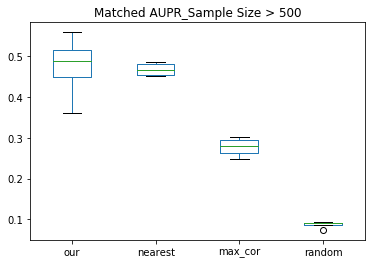

/home1/alfred/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/morestats.py:2879: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


WilcoxonResult(statistic=17.0, pvalue=0.3060449400446284)

In [13]:
name, auprs = 'Matched AUPR', matched_tissue_auprs
df = pd.DataFrame(auprs, index=['our', 'nearest', 'max_cor', 'random']).transpose()

a = tissue_map['Sample_size'].quantile(0.33)
b = 500

inx_bb = tissue_map[tissue_map['Sample_size'] > b]['FANTOM_ID'].to_list()
inx_bb = [True if i.split('-')[-1] in inx_bb else False for i in df.index]



# df.loc[inx_bb].plot.bar(title=name + '_Sample Size > %d' %b, figsize=[12, 6])
df.loc[inx_bb].plot.box(title=name+'_Sample Size > %d' %b)
plt.show()

import scipy
scipy.stats.wilcoxon(df.loc[inx_bb]['our'].values, y=df.loc[inx_bb]['nearest'].values, alternative='greater')

<IPython.core.display.Javascript object>


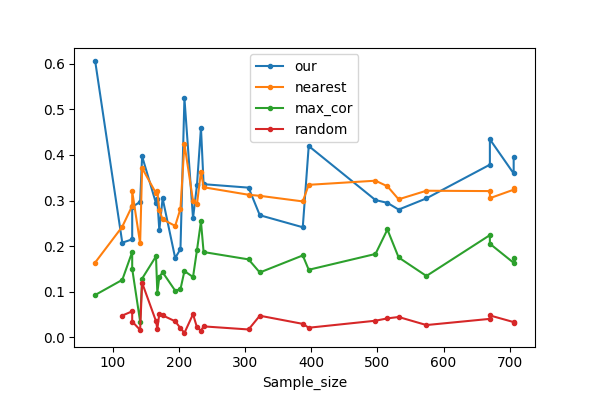

our            0.143768
nearest        0.324745
max_cor        0.484599
random        -0.076735
Sample_size    1.000000
Name: Sample_size, dtype: float64

In [70]:
# promoter -> enhancer
df_ = df.copy()
df_.index = [i.split('-')[-1] for i in df_.index.values]
df_ = df_.merge(tissue_map[['FANTOM_ID', 'Sample_size']], how='left', left_index=True, right_on='FANTOM_ID')
df_ = df_.sort_values(by='Sample_size')
x = df_.plot.line(x='Sample_size', y=['our', 'nearest', 'max_cor', 'random'], marker='.')
df_.corr()['Sample_size']

In [34]:
1

1

In [ ]:
name, auprs = 'Matched AUPR', matched_tissue_auprs
df = pd.DataFrame(auprs, index=['our', 'nearest', 'max_cor', 'random']).transpose()

a = tissue_map['Sample_size'].quantile(0.33)
b = 500

inx_bb = tissue_map[tissue_map['Sample_size'] > b]['FANTOM_ID'].to_list()
inx_bb = [True if i.split('-')[-1] in inx_bb else False for i in df.index]



# df.loc[inx_bb].plot.bar(title=name + '_Sample Size > %d' %b, figsize=[12, 6])
df.loc[inx_bb].plot.box(title=name+'_Sample Size > %d' %b)
plt.show()

import scipy
scipy.stats.wilcoxon(df.loc[inx_bb]['our'].values, y=df.loc[inx_bb]['nearest'].values, alternative='greater')

<IPython.core.display.Javascript object>


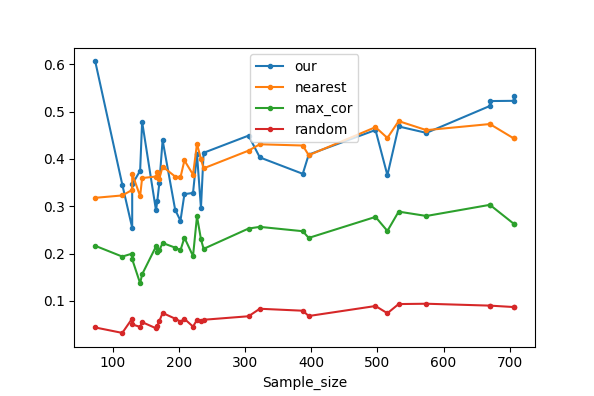

our            0.557853
nearest        0.881326
max_cor        0.797069
random         0.865987
Sample_size    1.000000
Name: Sample_size, dtype: float64

In [90]:
# enhancer -> promoter
df_ = df.copy()
df_.index = [i.split('-')[-1] for i in df_.index.values]
df_ = df_.merge(tissue_map[['FANTOM_ID', 'Sample_size']], how='left', left_index=True, right_on='FANTOM_ID')
df_ = df_.sort_values(by='Sample_size')
x = df_.plot.line(x='Sample_size', y=['our', 'nearest', 'max_cor', 'random'], marker='.')
df_.corr()['Sample_size']

<IPython.core.display.Javascript object>


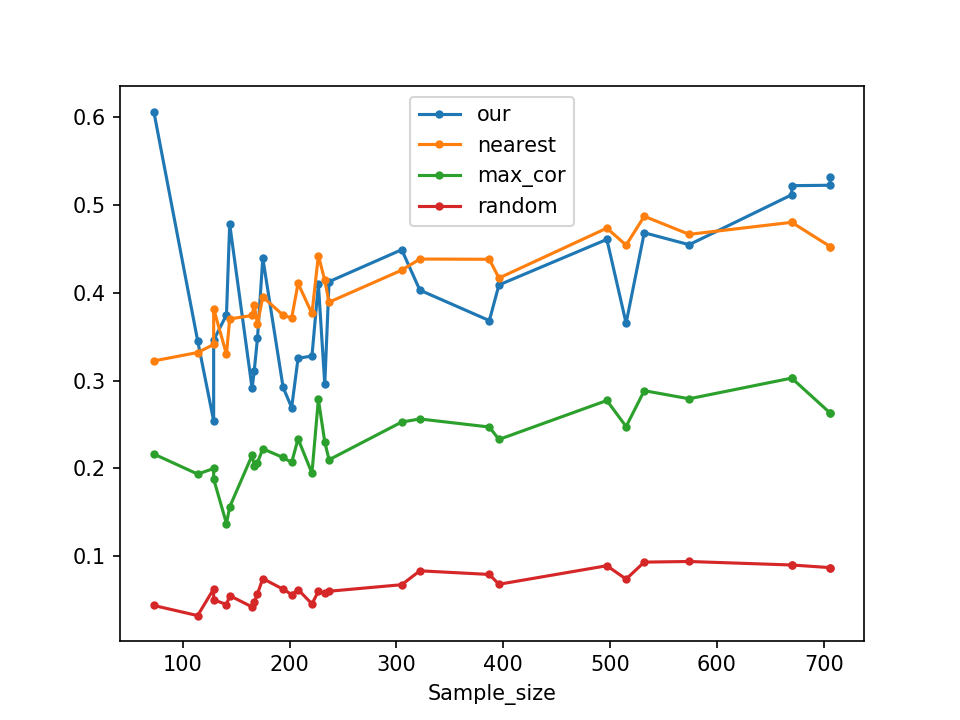

our            0.557853
nearest        0.871686
max_cor        0.797069
random         0.865987
Sample_size    1.000000
Name: Sample_size, dtype: float64

In [32]:
# default bedtool closest
df_ = df.copy()
df_.index = [i.split('-')[-1] for i in df_.index.values]
df_ = df_.merge(tissue_map[['FANTOM_ID', 'Sample_size']], how='left', left_index=True, right_on='FANTOM_ID')
df_ = df_.sort_values(by='Sample_size')
x = df_.plot.line(x='Sample_size', y=['our', 'nearest', 'max_cor', 'random'], marker='.')
df_.corr()['Sample_size']
# df_

<IPython.core.display.Javascript object>


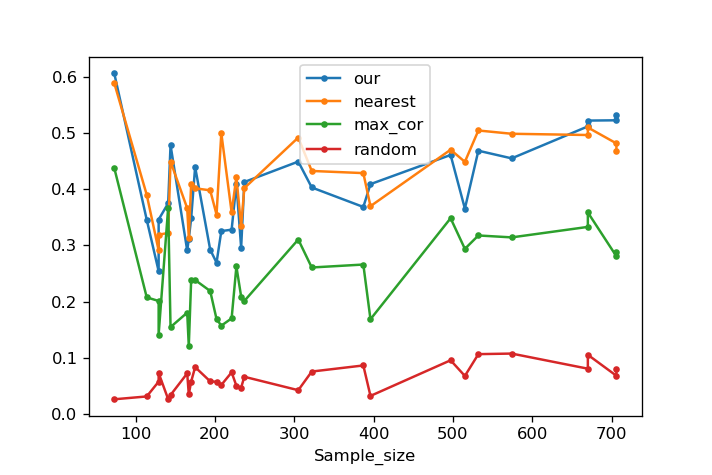

our            0.557853
nearest        0.521688
max_cor        0.459444
random         0.644621
Sample_size    1.000000
Name: Sample_size, dtype: float64

In [120]:
#  enhancer -> promoter and intersect to tissue specific active enhancer
df_ = df.copy()
df_.index = [i.split('-')[-1] for i in df_.index.values]
df_ = df_.merge(tissue_map[['FANTOM_ID', 'Sample_size']], how='left', left_index=True, right_on='FANTOM_ID')
df_ = df_.sort_values(by='Sample_size')
x = df_.plot.line(x='Sample_size', y=['our', 'nearest', 'max_cor', 'random'], marker='.')
df_.corr()['Sample_size']

<IPython.core.display.Javascript object>


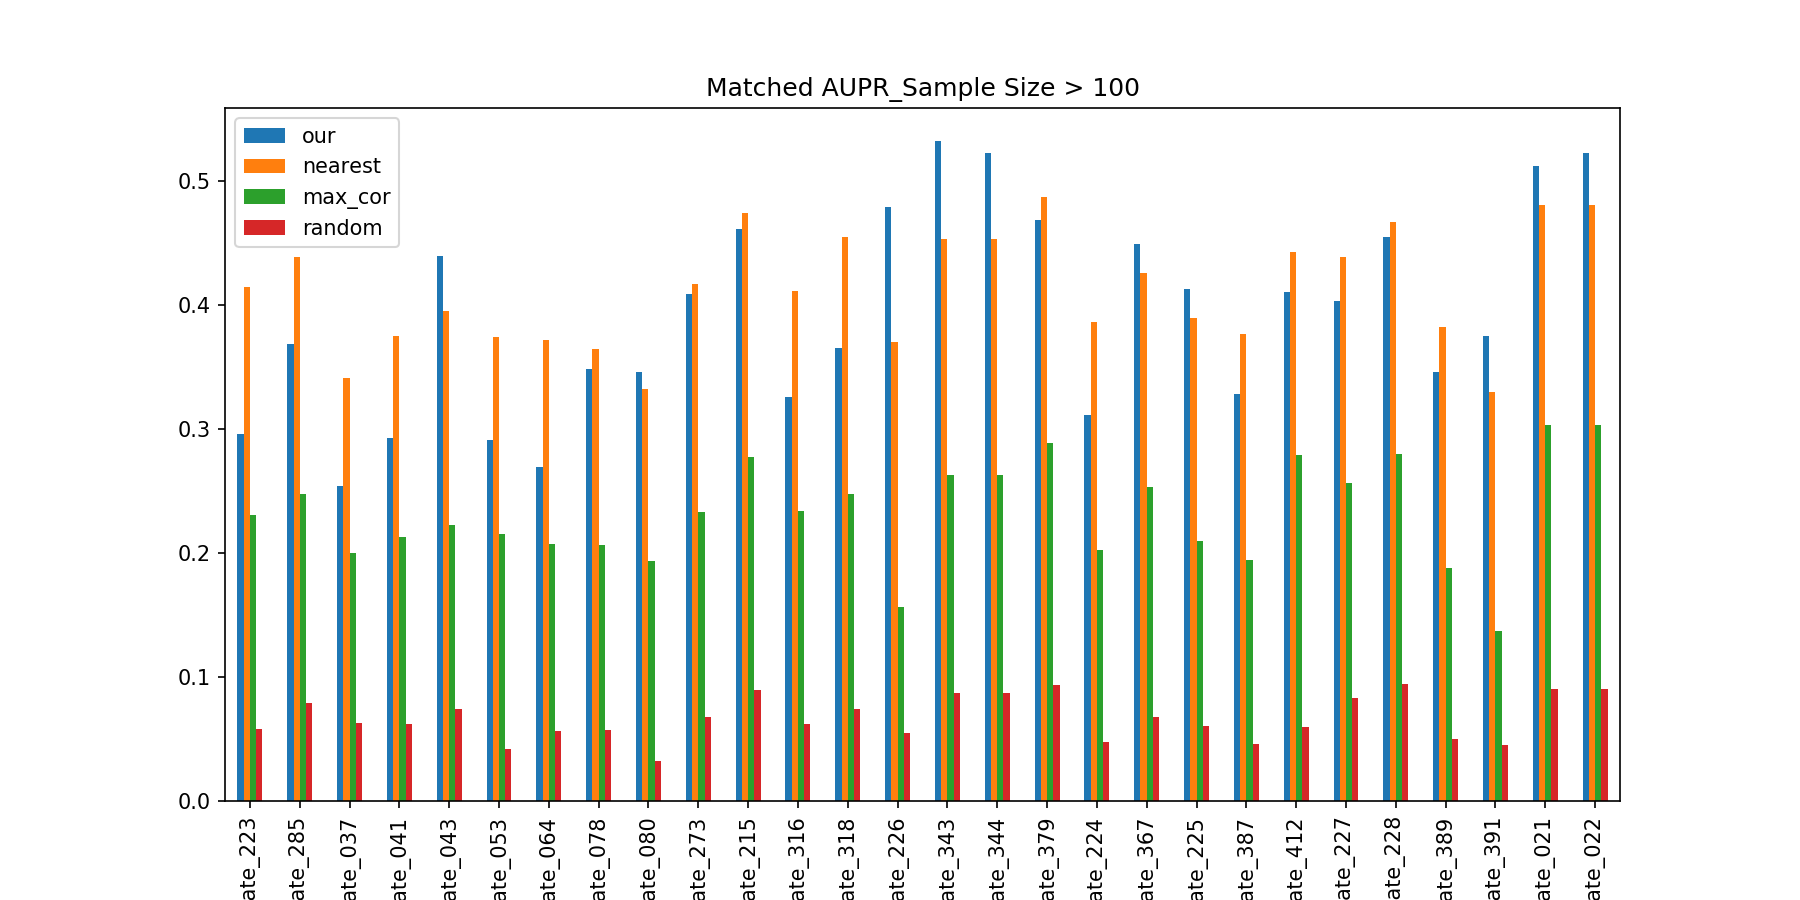

<IPython.core.display.Javascript object>


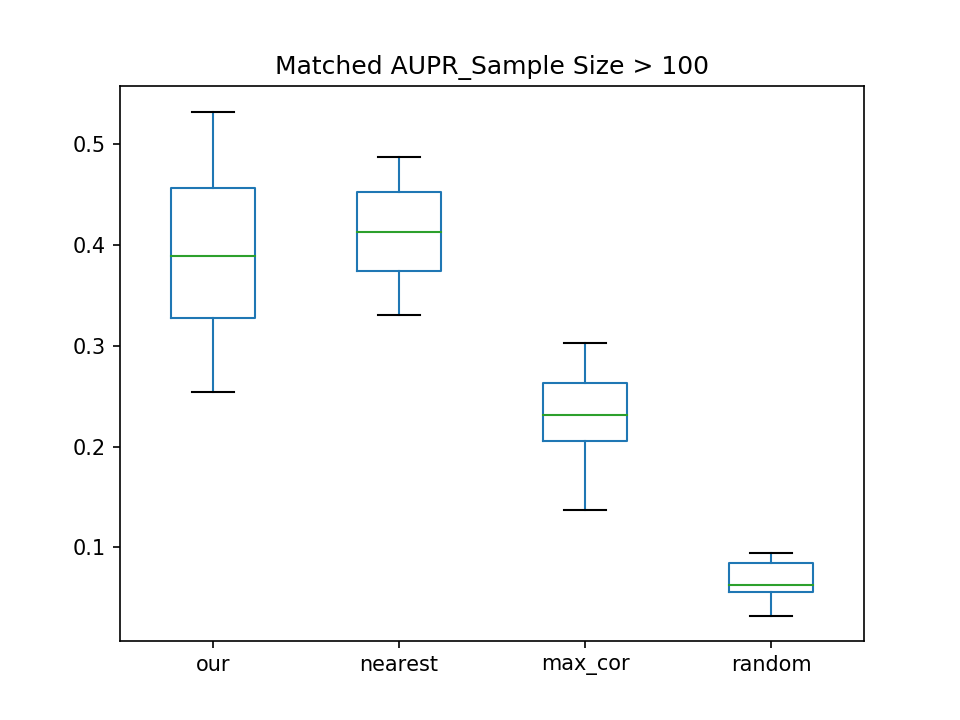

WilcoxonResult(statistic=135.0, pvalue=0.9392438214457537)

In [38]:
name, auprs = 'Matched AUPR', matched_tissue_auprs
df = pd.DataFrame(auprs, index=['our', 'nearest', 'max_cor', 'random']).transpose()

a = tissue_map['Sample_size'].quantile(0.33)
b = 100

inx_bb = tissue_map[tissue_map['Sample_size'] > b]['FANTOM_ID'].to_list()
inx_bb = [True if i.split('-')[-1] in inx_bb else False for i in df.index]



df.loc[inx_bb].plot.bar(title=name + '_Sample Size > %d' %b, figsize=[12, 6])
df.loc[inx_bb].plot.box(title=name+'_Sample Size > %d' %b)
plt.show()

import scipy
scipy.stats.wilcoxon(df.loc[inx_bb]['our'].values, y=df.loc[inx_bb]['nearest'].values, alternative='greater')